In [ ]:
import os
from os import walk
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#transform = transforms.Compose([transforms.ToTensor()])
#dataset = datasets.ImageFolder('Dataset', transform=transform)

### 1. Check if data loader is working and visualize the cropped images

In [ ]:
### Load the dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
### Check if loading has been correcty


# define helper.py
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

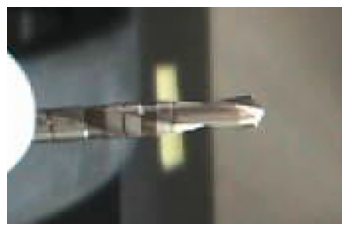

In [ ]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [ ]:
train_transforms = transforms.Compose([transforms.GaussianBlur(kernel_size = 5),
                                       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                                       transforms.ToTensor()])

train_transforms = transforms.Compose([transforms.ToTensor()])

In [ ]:
test_transforms = transforms.Compose([transforms.ToTensor()])

In [ ]:
data_dir = 'Dataset'

In [ ]:
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

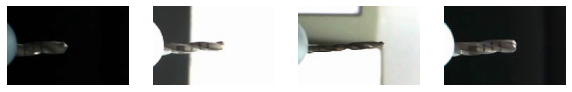

In [ ]:
# change this to the trainloader or testloader
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    imshow(images[ii], ax=ax, normalize=False)

### 2. Write model definition using nn module

In [ ]:


class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        #############################################################################
        # Initialize the network weights                                      #
        #############################################################################
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        self.maxpool =  nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(64)
        self.fc3 = nn.LazyLinear(9)
        #self.dropout = nn.Dropout(p=0.5)
        #############################################################################
        #                              END                         #
        #############################################################################

    def forward(self, x):
        outs = None
        #############################################################################
        #forward pass of the network                               #
        #############################################################################
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        outs = self.fc3(x)
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return outs

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net = MyModel()

In [ ]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [ ]:
### Hyperparamters

batch_size = 32
learning_rate = 0.005
reg = 0.0005
epochs = 5
steps = [6, 8]
warmup = 0
momentum = 0.9

### 3. Train the model and save the best model to checkpoints folder

In [ ]:
### ----------------TRAIN script-------------------


import yaml
import argparse
import time
import copy
import os

import numpy as np
import torch
import torchvision


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.shape[0]

    _, pred = torch.max(output, dim=-1)

    correct = pred.eq(target).sum() * 1.0

    acc = correct.item() / batch_size

    return acc

def train(epoch, data_loader, model, optimizer, criterion):

    iter_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    for idx, (data, target) in enumerate(data_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        #############################################################################
        ### TRAIN LOOP
        out = model(data)

        torch_loss = criterion(out, target)

        torch_loss.backward()

        loss = torch_loss.item()

        optimizer.step()

        optimizer.zero_grad()

        batch_acc = accuracy(out, target)

        losses.update(loss, out.shape[0])
        acc.update(batch_acc, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 10 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec @1 {top1.val:.4f} ({top1.avg:.4f})\t')
                   .format(epoch, idx, len(data_loader), iter_time=iter_time, loss=losses, top1=acc))


def validate(epoch, val_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    num_class = 9
    cm =torch.zeros(num_class, num_class)
    # evaluation loop
    for idx, (data, target) in enumerate(val_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        with torch.no_grad():

            out = model(data)

            loss = criterion(out, target).item()

        batch_acc = accuracy(out, target)

        # update confusion matrix
        _, preds = torch.max(out, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1

        losses.update(loss, out.shape[0])
        acc.update(batch_acc, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 10 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
               'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t')
               .format(epoch, idx, len(val_loader), iter_time=iter_time, loss=losses, top1=acc))
    cm = cm / cm.sum(1)
    per_cls_acc = cm.diag().detach().numpy().tolist()
    for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

    print("* Prec @1: {top1.avg:.4f}".format(top1=acc))
    return acc.avg, cm


def adjust_learning_rate(optimizer, epoch):
    epoch += 1
    if epoch <= warmup:
        lr = learning_rate * epoch / warmup
    elif epoch > steps[1]:
        lr = learning_rate * 0.01
    elif epoch > steps[0]:
        lr = learning_rate * 0.1
    else:
        lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def main():
    #global args
    #args = parser.parse_args()
    #with open(args.config) as f:
    #    config = yaml.load(f, Loader=yaml.Loader)

    #for key in config:
    #    for k, v in config[key].items():
    #        setattr(args, k, v)

    transform_train = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Normalize the test set same as training set without augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    data_dir = 'Dataset'

    train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)


    model = MyModel()
    print(model)
    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                                momentum=momentum,
                                weight_decay=reg)
    best = 0.0
    best_cm = None
    best_model = None
    for epoch in range(epochs):
        adjust_learning_rate(optimizer, epoch)

        # train loop
        train(epoch, train_loader, model, optimizer, criterion)

        # validation loop
        acc, cm = validate(epoch, test_loader, model, criterion)

        if acc > best:
            best = acc
            best_cm = cm
            best_model = copy.deepcopy(model)

    print('Best Prec @1 Acccuracy: {:.4f}'.format(best))
    per_cls_acc = best_cm.diag().detach().numpy().tolist()
    for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

    if True:
        if not os.path.exists('./checkpoints'):
            os.makedirs('./checkpoints')
        torch.save(best_model.state_dict(), './checkpoints/' + 'mymodel' + '.pth')

if __name__ == '__main__':
    main()

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=64, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=9, bias=True)
)
Epoch: [0][0/182]	Time 0.041 (0.041)	Loss 2.2032 (2.2032)	Prec @1 0.0625 (0.0625)	
Epoch: [0][10/182]	Time 0.037 (0.039)	Loss 2.2110 (2.1960)	Prec @1 0.0938 (0.1335)	
Epoch: [0][20/182]	Time 0.037 (0.038)	Loss 2.2029 (2.1968)	Prec @1 0.0938 (0.1205)	
Epoch: [0][30/182]	Time 0.037 (0.038)	Loss 2.2011 (2.1973)	Prec @1 0.1875 (0.1169)	
Epoch: [0][40/182]	Time 0.037 (0.038)	Loss 2.2080 (2.1988)	Prec @1 0.1250 (0.1105)	
Ep

Epoch: [3][170/182]	Time 0.037 (0.038)	Loss 0.0158 (0.0569)	Prec @1 1.0000 (0.9823)	
Epoch: [3][180/182]	Time 0.038 (0.038)	Loss 0.0082 (0.0553)	Prec @1 1.0000 (0.9827)	
Epoch: [3][0/46]	Time 0.014 (0.014)	
Epoch: [3][10/46]	Time 0.013 (0.014)	
Epoch: [3][20/46]	Time 0.013 (0.014)	
Epoch: [3][30/46]	Time 0.014 (0.014)	
Epoch: [3][40/46]	Time 0.014 (0.014)	
Accuracy of Class 0: 1.0000
Accuracy of Class 1: 0.9938
Accuracy of Class 2: 0.9877
Accuracy of Class 3: 1.0000
Accuracy of Class 4: 0.9938
Accuracy of Class 5: 1.0000
Accuracy of Class 6: 0.9938
Accuracy of Class 7: 1.0000
Accuracy of Class 8: 1.0000
* Prec @1: 0.9966
Epoch: [4][0/182]	Time 0.039 (0.039)	Loss 0.0151 (0.0151)	Prec @1 1.0000 (1.0000)	
Epoch: [4][10/182]	Time 0.037 (0.039)	Loss 0.0142 (0.0301)	Prec @1 1.0000 (0.9943)	
Epoch: [4][20/182]	Time 0.037 (0.038)	Loss 0.0105 (0.0329)	Prec @1 1.0000 (0.9881)	
Epoch: [4][30/182]	Time 0.037 (0.038)	Loss 0.0691 (0.0260)	Prec @1 0.9688 (0.9909)	
Epoch: [4][40/182]	Time 0.038 (0.038

### 4. Visualization

Text(0.5, 1.0, 'Evolution of accuracy')

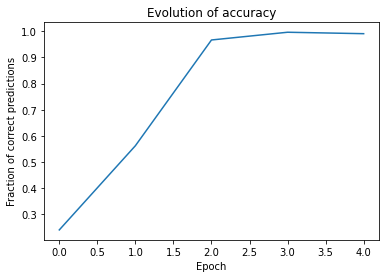

In [ ]:
plt.plot(np.arange(5), [0.2399, 0.5622, 0.9670,0.9966, 0.9911]) #Accuracy for every epoch
plt.xlabel('Epoch')
plt.ylabel('Fraction of correct predictions')
plt.title('Evolution of accuracy')

### Note: I have hard coded accuracy and loss for the moment, but it can be integrated in the pipeline

Text(0.5, 1.0, 'Evolution of loss')

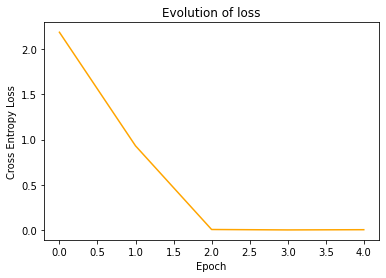

In [ ]:
plt.plot(np.arange(5), [2.1856, 0.9316, 0.0080,0.0034, 0.0058], color = 'orange') # Loss for every epoch
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Evolution of loss')